# Tutorial on NERDS_OSMnx

On this Notebook, we will see how the different functions on the package can be used on a basic example, first on a toy graph, then on the road and bicycle network extracted from OpenStreetMap on Frederiksberg, Denmark. This will show the difference between the simplification function of NERDS_OSMnx and OSMnx.

First, we import the necessary packages for this tutorial.

In [1]:
# Custom packages
import nerds_osmnx.simplification as sf
import nerds_osmnx.utils as utils

# Network
import osmnx as ox
import networkx as nx

## Toy Graph

A toy graph should be simple enough to be easy and quick to manipulate and analyze, but complete enough so we can test various possibilities. As you will see the construction is a bit tedious, but it's really quick and easy to use it afterwards. For this toy graph, we will test first the discrimination of attributes in the simplification process, and then how we can handle self-loop and multiple path between nodes to transform a MultiDiGraph into a Graph. Here the influence of the directness of edges will not be tested, nor the capacity to handle multiple attributes to discriminate.

We first manually construct the graph, by adding nodes and edges to an empty networkx MultiDiGraph. Using the same structure as networks extracted with OSMnx, we have as node attribute x  as longitude and y as latitude, and the graph have a crs attribute (for Coordinate Reference Systems).

In [2]:
G = nx.MultiDiGraph()
G.graph['crs'] = 'epsg:4326'
G.add_node(1, x=1, y=1) 
G.add_node(2, x=2, y=1) 
G.add_node(3, x=2.5, y=1.5)
G.add_node(4, x=3, y=2.5)
G.add_node(5, x=3.5, y=3.5)
G.add_node(6, x=3, y=4)
G.add_node(7, x=3, y=5)
G.add_node(8, x=3.5, y=5.5)
G.add_node(9, x=3.5, y=6.5)
G.add_node(10, x=4, y=7)
G.add_node(11, x=5, y=8)
G.add_node(12, x=6, y=8)
G.add_node(13, x=6.5, y=8.5)
G.add_node(14, x=7, y=9)
G.add_node(15, x=7.5, y=8.5)
G.add_node(16, x=8, y=8)
G.add_node(17, x=7.5, y=7.5)
G.add_node(18, x=7, y=7)
G.add_node(19, x=6.5, y=7.5)
G.add_node(20, x=4, y=4)
G.add_node(21, x=4, y=5)

print("Number of nodes:", len(G))

Number of nodes: 21


For the edges, we need to add length and osmid attributes in order to make the osmnx functions work.

In [3]:
for i in range(1, 19):
    G.add_edge(i, i+1, 0, length=1, osmid=i)
G.add_edge(5, 20, 0, length=1, osmid=20)
G.add_edge(20, 21, 0, length=1, osmid=21)
G.add_edge(21, 8, 0, length=1, osmid=22)
G.add_edge(19, 12, 0, length=1, osmid=23)

print("Number of edges:", len(list(G.edges)))

Number of edges: 22


We then add the attribute that we want to discriminate, that we will call here color, and to make it easy to visualize we will choose 3 integers as values, because the osmnx function to get edge colors by attribute doesn't handle list of strings. It's purely for visualization purpose, the simplification in itself work for every type of values.

In [4]:
for i in range(2, 8):
    G.edges[i, i+1, 0]['color'] = 1
G.edges[1, 2, 0]['color'] = 2
G.edges[5, 20, 0]['color'] = 1
G.edges[20, 21, 0]['color'] = 1
G.edges[21, 8, 0]['color'] = 1
for i in range(8, 11):
    G.edges[i, i+1, 0]['color'] = 3
for i in range(11, 19):
    G.edges[i, i+1, 0]['color'] = 2
G.edges[19, 12, 0]['color'] = 2

f_node = 5
s_node = 20
print(f"The edge between the node {f_node} and {s_node} have as color the value {G.edges[f_node, s_node, 0]['color']}")

The edge between the node 5 and 20 have as color the value 1


We can first visualize our toy graph initially:

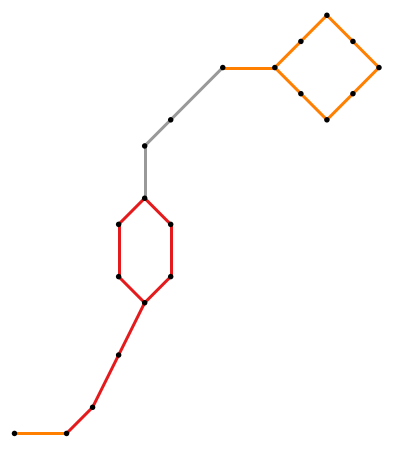

Number of nodes: 21
Number of edges: 22


In [5]:
ec = ox.plot.get_edge_colors_by_attr(G, 'color', cmap='Set1')
ox.plot_graph(G, figsize=(12, 8), bgcolor='w', node_color='black', node_size=30, edge_color=ec, edge_linewidth=3)
print("Number of nodes:", len(G))
print("Number of edges:", len(list(G.edges)))

We look at how osmnx would simplify this network. We can't put colors here because for some edges the color attributes will be a list and in other instances an integer. We can still see how nodes that shouldn't be simplified (the second one at the bottom, the one before the self-loop at the top) are simplified if we don't take into account the attribute:

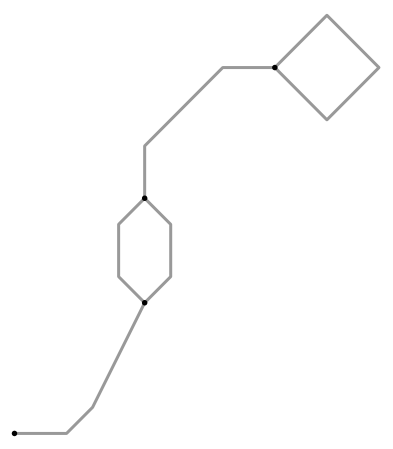

Number of nodes: 4
Number of edges: 5


In [6]:
ox_G = ox.simplify_graph(G)
ox.plot_graph(ox_G, figsize=(12, 8), bgcolor='w', node_color='black', node_size=30, edge_linewidth=3)
print("Number of nodes:", len(ox_G))
print("Number of edges:", len(list(ox_G.edges)))

We make sure that the modified simplification function give the same results in case we don't specify an attribute to discriminate:

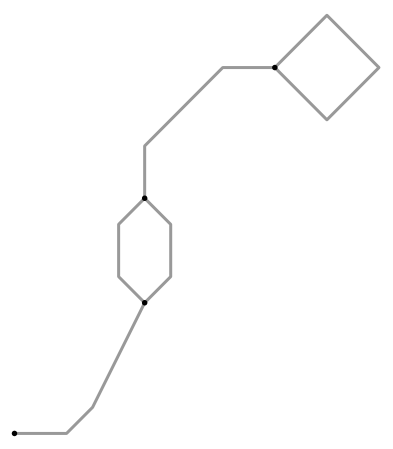

Number of nodes: 4
Number of edges: 5


In [7]:
nerds_woattr_G = sf.simplify_graph(G)
ox.plot_graph(nerds_woattr_G, figsize=(12, 8), bgcolor='w', node_color='black', node_size=30, edge_linewidth=3)
print("Number of nodes:", len(nerds_woattr_G))
print("Number of edges:", len(list(nerds_woattr_G.edges)))

We look at the resulting graph in case we discriminate with the color attribute. As we can see, the bottom and top nodes specified before that are between edges with different values for the attribute color are kept.

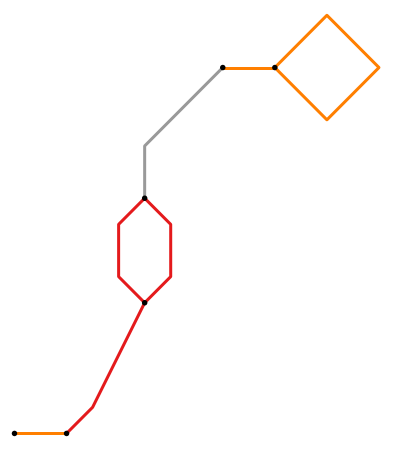

Number of nodes: 6
Number of edges: 7


In [8]:
G_simple = sf.simplify_graph(G, attributes='color')
ec_s = ox.plot.get_edge_colors_by_attr(G_simple, 'color', cmap='Set1')
ox.plot_graph(G_simple, figsize=(12, 8), bgcolor='w', node_color='black', node_size=30, edge_color=ec_s, edge_linewidth=3)
print("Number of nodes:", len(G_simple))
print("Number of edges:", len(list(G_simple.edges)))

Now that we have a simplified network with an attribute correctly discriminated, we can then look at how the MultiDiGraph is transformed into a Graph: for self-loop, the first and last points of the LineString making the geometry of the edge are transformed into nodes, and for multiple path, on every path except one, with curved paths in priority of straight paths, the first point of the LineString is transformed into a node.


              Number of self-loop found : 1 

              Number of multiple path between nodes found : {2: 1}
              


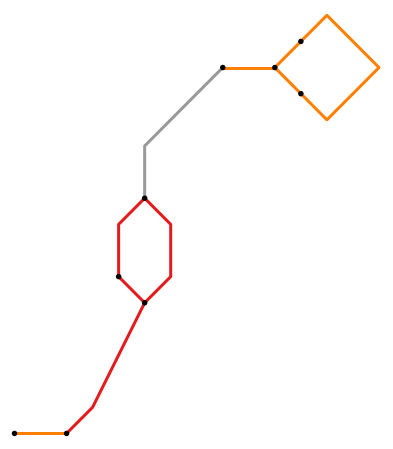

The debug argument gives us this dictionary: {'self-loop': [[[12, 13, 14, 15, 16, 17, 18, 23], <shapely.geometry.linestring.LineString object at 0x00000146D12A9700>]], 'multiple-path': [[[5, 6, 7], <shapely.geometry.linestring.LineString object at 0x00000146D12A9FD0>], [[20, 21, 22], <shapely.geometry.linestring.LineString object at 0x00000146D12A96D0>]]}


In [9]:
G_graph, debug_dict = sf.multidigraph_to_graph(G_simple, verbose=True, debug=True)
ec_g = ox.plot.get_edge_colors_by_attr(G_graph, 'color', cmap='Set1')
G_graph = nx.MultiGraph(G_graph)
ox.plot_graph(G_graph, figsize=(12, 8), bgcolor='w', node_color='black', node_size=30, edge_color=ec_g, edge_linewidth=3)
print("The debug argument gives us this dictionary:", debug_dict)

One issue you might encounter is that not every edge have a geometry attribute when using simplify_graph, because edges that have not been simplified (between two endpoints or non-intersection nodes) are not given one.

In [10]:
G_simple.edges(data=True)

OutMultiEdgeDataView([(1, 2, {'length': 1, 'osmid': 1, 'color': 2}), (2, 5, {'length': 3, 'osmid': [2, 3, 4], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9910>}), (5, 8, {'length': 3, 'osmid': [5, 6, 7], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9FD0>}), (5, 8, {'length': 3, 'osmid': [20, 21, 22], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A96D0>}), (8, 11, {'length': 3, 'osmid': [8, 9, 10], 'color': 3, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9EB0>}), (11, 12, {'length': 1, 'osmid': 11, 'color': 2}), (12, 12, {'length': 8, 'osmid': [12, 13, 14, 15, 16, 17, 18, 23], 'color': 2, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9700>})])

This is not the case when you're also using the multidigraph_to_graph function, because this function use the get_undirected function from OSMnx, which is adding a geometry attribute to every non-simplified edges (to compare the geometry of parallel edges)

In [11]:
G_graph.edges(data=True)

MultiEdgeDataView([(1, 2, {'length': 1, 'osmid': 1, 'color': 2, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D152A3A0>}), (2, 5, {'length': 3, 'osmid': [2, 3, 4], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9910>}), (5, 8, {'length': 3, 'osmid': [20, 21, 22], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A96D0>}), (5, 6, {'osmid': [5, 6, 7], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D05A14F0>, 'length': 78542.541}), (8, 11, {'length': 3, 'osmid': [8, 9, 10], 'color': 3, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9EB0>}), (8, 6, {'osmid': [5, 6, 7], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D14EB0D0>, 'length': 175754.059}), (11, 12, {'length': 1, 'osmid': 11, 'color': 2, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D152AA00>}), (12, 1

In the case you want to add a geometry attribute to every non-simplified edges without changing the type of graph you have, you can just use the add_geometry_attribute function:

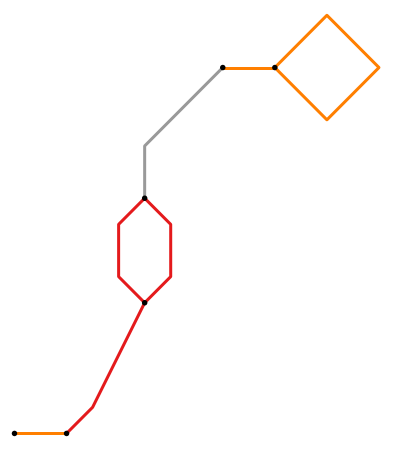

OutMultiEdgeDataView([(1, 2, {'length': 1, 'osmid': 1, 'color': 2, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D17CFE20>}), (2, 5, {'length': 3, 'osmid': [2, 3, 4], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9910>}), (5, 8, {'length': 3, 'osmid': [5, 6, 7], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9FD0>}), (5, 8, {'length': 3, 'osmid': [20, 21, 22], 'color': 1, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A96D0>}), (8, 11, {'length': 3, 'osmid': [8, 9, 10], 'color': 3, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9EB0>}), (11, 12, {'length': 1, 'osmid': 11, 'color': 2, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D059E2B0>}), (12, 12, {'length': 8, 'osmid': [12, 13, 14, 15, 16, 17, 18, 23], 'color': 2, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000146D12A9700

In [12]:
G_new = sf.add_geometry_attribute(G_simple)
ec_n = ox.plot.get_edge_colors_by_attr(G_new, 'color', cmap='Set1')
ox.plot_graph(G_new, figsize=(12, 8), bgcolor='w', node_color='black', node_size=30, edge_color=ec_n, edge_linewidth=3)
G_new.edges(data=True)

As we can see, every functions are working as intended, we can now try them on real data to see what an actual workflow for this looks like.

## Example on Frederiksberg

We first start by adding tags to osmnx in order to get useful attributes on edges for a bicycle network:

In [13]:
tag_list = ["cycleway", "bicycle", "cycleway:right", "cycleway:left", "cyclestreet", "bicycle_road"]
for tag_name in tag_list:
    if tag_name not in ox.settings.useful_tags_way:
        ox.settings.useful_tags_way += [tag_name]

We then retrieve the road network of Frederiksberg with OSMnx. Here we get the polygon of the administrative boundary of Frederiksberg with a query through OSMnx and then find the graph for this polygon, we could also directly use the function ox.graph_from_place("Frederiksberg Municipality") that does exactly this.

In [14]:
fre = ox.geocode_to_gdf("Frederiksberg Municipality")
G = ox.graph_from_polygon(fre['geometry'][0], simplify=False)

print("Number of nodes:", len(G))
print("Number of edges:", len(list(G.edges)))

Number of nodes: 14460
Number of edges: 31171


As we can see, the unsimplified graph is huge with a lot of useless nodes and edges:

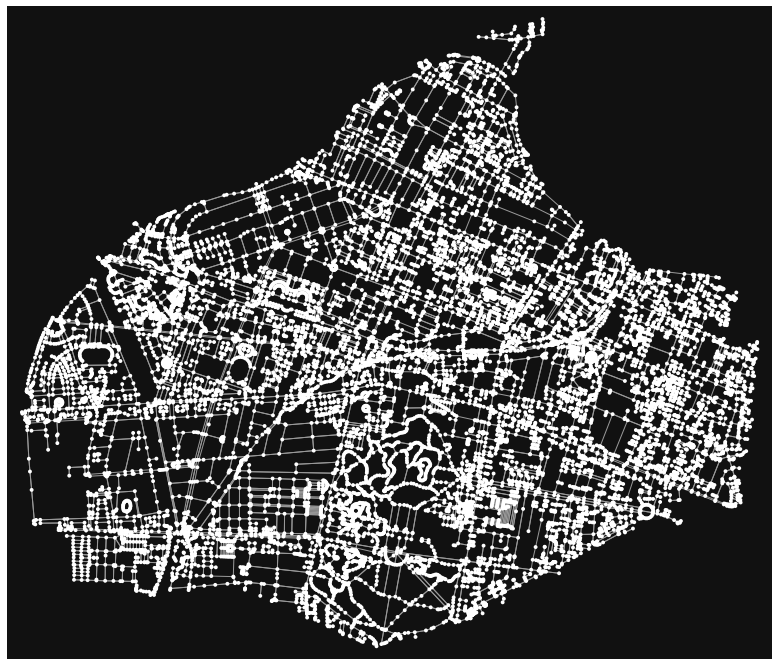

(<Figure size 1152x864 with 1 Axes>, <AxesSubplot:>)

In [15]:
ox.plot_graph(G, figsize=(16,12))

We can see what the network looks like if we simplify without considering any attribute:

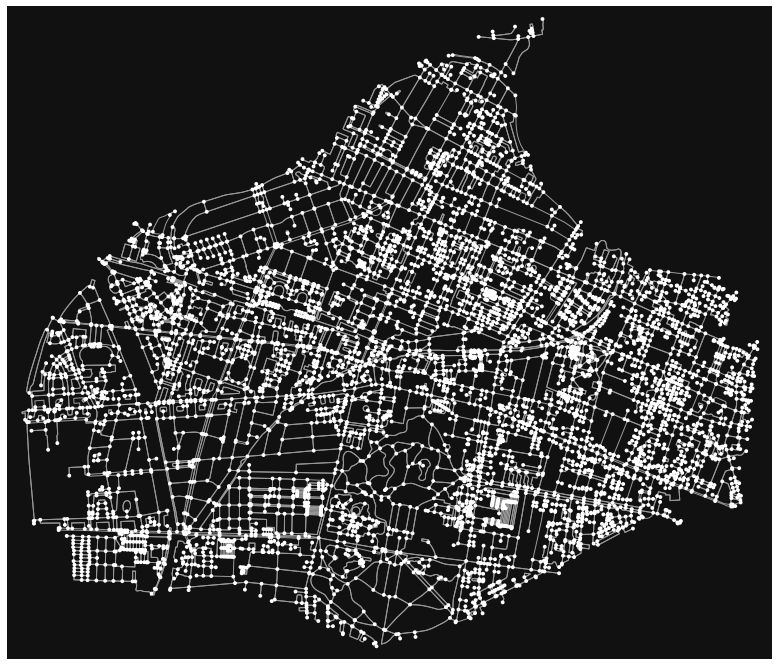

Number of nodes: 6270
Number of edges: 15407


In [16]:
ox_G = ox.simplify_graph(G)
ox.plot_graph(ox_G, figsize=(16,12))

print("Number of nodes:", len(ox_G))
print("Number of edges:", len(list(ox_G.edges)))

For now, we have a lot of different attributes scattered for bicycle infrastructure, so before simplifying on all corresponding attributes we should make a new attribute for every edges that combine all of those potential bicycle infrastructures. In order to do so, we make a dictionary with keys as attributes, and values as the accepted values for those attributes in order to make our new attribute true. We make a new graph with an attribute named protected bicycling, which is true when one of the possible protected bicycle infrastructure is here, and false otherwise.

In [17]:
protected_dict = dict()
protected_dict["cycleway"] = "track"
protected_dict["cycleway:right"] = "track"
protected_dict["cycleway:left"] = "track"
protected_dict["bicycle_road"] = "yes"
protected_dict["bicycle"] = "designated"
protected_dict["highway"] = "cycleway"

H = utils.add_edge_attribute(G, protected_dict, 'protected_bicycling')

f_edge = list(H.edges)[0]
print(f"Edge between node {f_edge[0]} and node {f_edge[1]}: {H.edges[f_edge]}")

Edge between node 576730 and node 1043162182: {'osmid': 162089324, 'name': 'Søndre Fasanvej', 'highway': 'tertiary', 'maxspeed': '50', 'cycleway': 'track', 'bicycle': 'yes', 'oneway': False, 'length': 10.666, 'protected_bicycling': True}


We then simplify this graph while discriminating for the protected bicycling attribute:

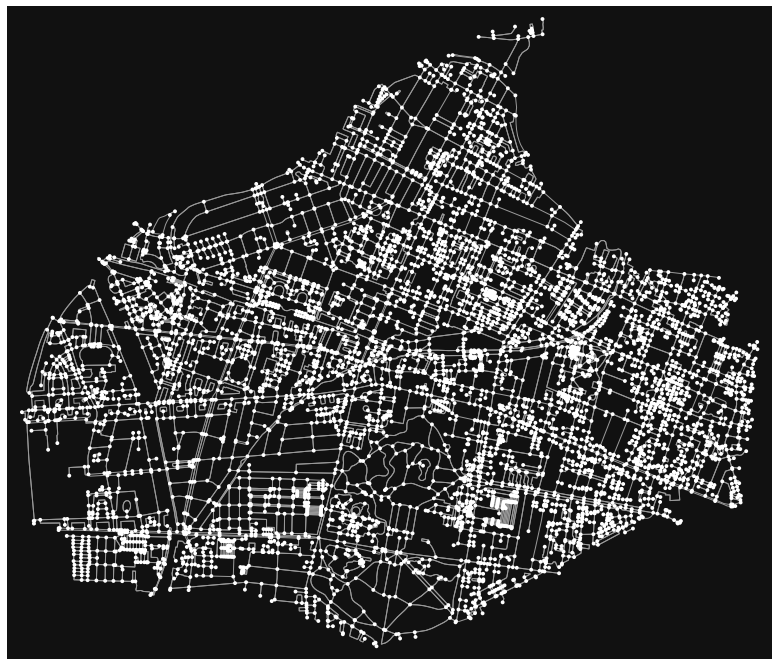

Number of nodes: 6294
Number of edges: 15455


In [18]:
H_sim = sf.simplify_graph(H, attributes='protected_bicycling')
ox.plot_graph(H_sim, figsize=(16,12))

print("Number of nodes:", len(H_sim))
print("Number of edges:", len(list(H_sim.edges)))

We can see some additional nodes and edges, but this is hard to see without visualizing the attribute value. To make it clearer quickly, we make the values of the attribute integers, and then color the edges by their attributes with osmnx. The red edges are with protected bicycle infrastructure, the blue one without:

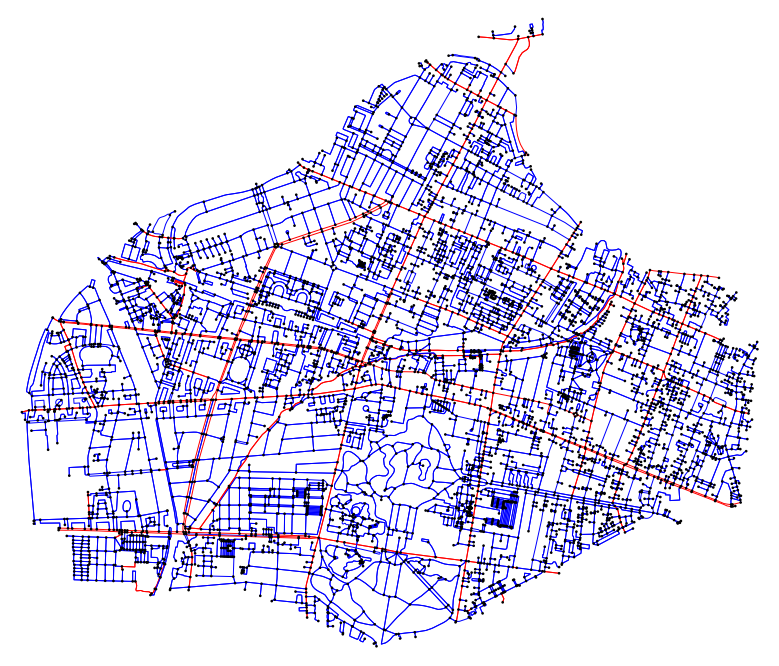

Number of nodes: 6294
Number of edges: 15455


In [19]:
H_col = H_sim.copy()
for edge in H_sim.edges:
    if H_col.edges[edge]['protected_bicycling'] is True:
        H_col.edges[edge]['protected_bicycling'] = 1
    else:
        H_col.edges[edge]['protected_bicycling'] = 0
ec = ox.plot.get_edge_colors_by_attr(H_col, 'protected_bicycling', cmap='bwr')
ox.plot_graph(H_col, figsize=(16,12),  bgcolor='w', node_color='black', node_size=7, edge_color=ec, edge_linewidth=1)

print("Number of nodes:", len(H_col))
print("Number of edges:", len(list(H_col.edges)))

Once our graph is simplified correctly, we can make this MultiDiGraph a Graph:

In [20]:
H_mul = sf.multidigraph_to_graph(H_col, attributes='protected_bicycling', verbose=True)

print(f"H_col is a {type(H_col)}, H_mul is a {type(H_mul)}")


                  Multiple straight path between node 4505878397 and 4505879466 
                  at the keys [0, 1]
                  

              Number of self-loop found : 42 

              Number of multiple path between nodes found : {2: 83, 3: 1}
              
H_col is a <class 'networkx.classes.multidigraph.MultiDiGraph'>, H_mul is a <class 'networkx.classes.graph.Graph'>


Because osmnx uses MultiDiGraph in the osmnx.plot_graph() function, we need to transform it back into a MultiDiGraph to visualize it. As we can see the number of nodes slightly increased because of the 2 nodes added by self-loop and the nodes added for multiple paths, but the number of edges (on the Graph, not the MultiDiGraph made with the Graph) is almost divided by 2, because most edges were doubled to go in both directions, so making them undirected divide their number by 2.

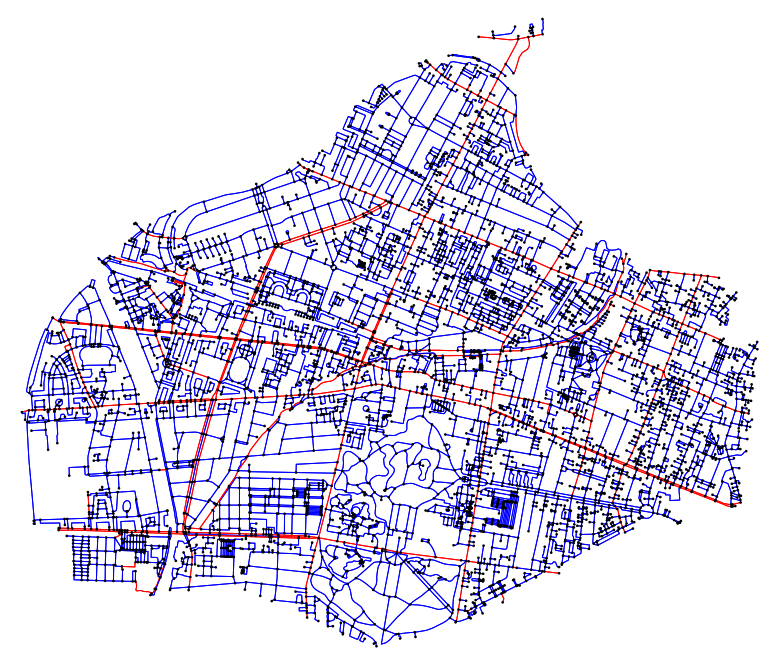

Number of nodes: 6463
Number of edges: 8415


In [21]:
ec = ox.plot.get_edge_colors_by_attr(nx.MultiDiGraph(H_mul), 'protected_bicycling', cmap='bwr')
ox.plot_graph(nx.MultiDiGraph(H_mul), figsize=(16,12),  bgcolor='w', node_color='black',
              node_size=7, edge_color=ec, edge_linewidth=1)

print("Number of nodes:", len(H_mul))
print("Number of edges:", len(list(H_mul.edges)))

## Conclusions

As we can see, a workflow for what these functions allow to can be summarized as such:

- Add to the list of tags retrieved by osmnx tags that we may use
- Extract the wanted network unsimplified with osmnx by specifying simplified=False
- Optionally create a new attribute based on useful tags
- Simplify the network while specifying attributes that we want to discriminate
- Transform this simplified network from a MultiDiGraph to a Graph
- Make network analysis
- Vizualize the network either with folium or by transforming the Graph into a MultiDiGraph again